`Programming language`: Python

`Libraries:` OpenCv, FastAi, Numpy, Matplotlib, Sklearn, PyTorch, Pillow

We install and iImport the opencv library, which will allow us to process the photo in an easy, simple and pleasant way using the tools available in it.

In [ ]:
pip install opencv-python

### Recognition using processing the image

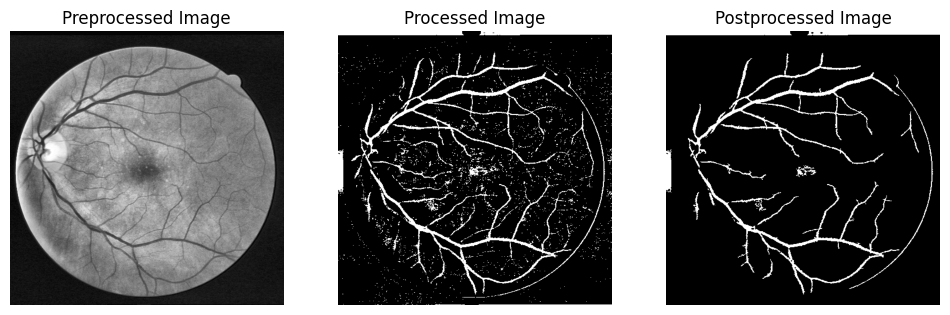

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def preprocess_image(image):
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(10, 10))
    image_equalized = clahe.apply(image)
    return image_equalized

def process_image(image):
    kernel_sizes = [1,3,5, 11]  # Adjusted kernel sizes
    thresh_val = 20  # Adjusted threshold value

    kernels = [cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size)) for size in kernel_sizes]

    morphology_steps = [image.copy()]
    for kernel in kernels:
        image_opened = cv2.morphologyEx(morphology_steps[-1], cv2.MORPH_OPEN, kernel, iterations=3)
        image_closed = cv2.morphologyEx(image_opened, cv2.MORPH_CLOSE, kernel, iterations=2)
        morphology_steps.extend([image_opened, image_closed])
    
    extracted_vessels = cv2.subtract(morphology_steps[-1], image)
    extracted_vessels_equalized = cv2.createCLAHE(clipLimit=4, tileGridSize=(5, 5)).apply(extracted_vessels)  # Adjusted tileGridSize
    
    _, extracted_vessels_equalized_threshold = cv2.threshold(extracted_vessels_equalized, thresh_val, 255, cv2.THRESH_BINARY)
    
    return extracted_vessels_equalized_threshold

def postprocess_image(image, max_noise_area=75):
    noise_mask = np.ones(image.shape[:2], dtype="uint8") * 255

    contours, _ = cv2.findContours(image.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) <= max_noise_area:
            cv2.drawContours(noise_mask, [contour], -1, 0, -1)

    extracted_vessels_corrected = cv2.bitwise_and(image, image, mask=noise_mask)
    
    return extracted_vessels_corrected



def get_vessels_process(image):
    # Preprocessing
    preprocessed_image = preprocess_image(image)
    # Processing
    processed_image = process_image(preprocessed_image)
    # Postprocessing
    postprocessed_image = postprocess_image(processed_image)
    
    return preprocessed_image, processed_image, postprocessed_image

def extract_vessels(image):
    preprocessed_image = preprocess_image(image)
    processed_image = process_image(preprocessed_image)
    postprocessed_image = postprocess_image(processed_image)
    return postprocessed_image

def show__process(pictures, labels):
    num_pictures = len(pictures)
    _, axes = plt.subplots(1, num_pictures, figsize=(num_pictures * 4, 4))
    
    for i in range(num_pictures):
        axes[i].imshow(pictures[i], cmap='gray') 
        axes[i].set_title(labels[i])
        axes[i].axis('off')
    plt.show()

image = cv2.imread('big-data/image/0.png', cv2.IMREAD_GRAYSCALE) 
extracted_vessels = get_vessels_process(image)
show__process(extracted_vessels, ['Preprocessed Image', 'Processed Image', 'Postprocessed Image'])


**Image processing for blood vessel extraction.**

**Image processing steps:**.

1 Pre-processing:
    - The contrast adaptive histogram screening algorithm (CLAHE) was applied to equalize the image histogram.

2-Processing:
    - Morphological opening and closing operation was applied to eliminate noise and improve vessel contours.
    - Different sizes of morphological kernels were used to account for different vessel scales.

3 Post-processing:
    - A contour segmentation algorithm was used to remove fine noise and irrelevant details.
    - Areas of less than 200 pixels were filtered out.

**Rationale for the solution used:**.

- CLAHE preprocessing: Allows for contrast equalization to facilitate detection of blood vessels.
  
- Morphological opening and closing operations: Reduce noise and improve vessel contours.
  
- Contour segmentation and noise elimination: Removes minor noise, leaving vital information about blood vessels.


Now, let's show the sample

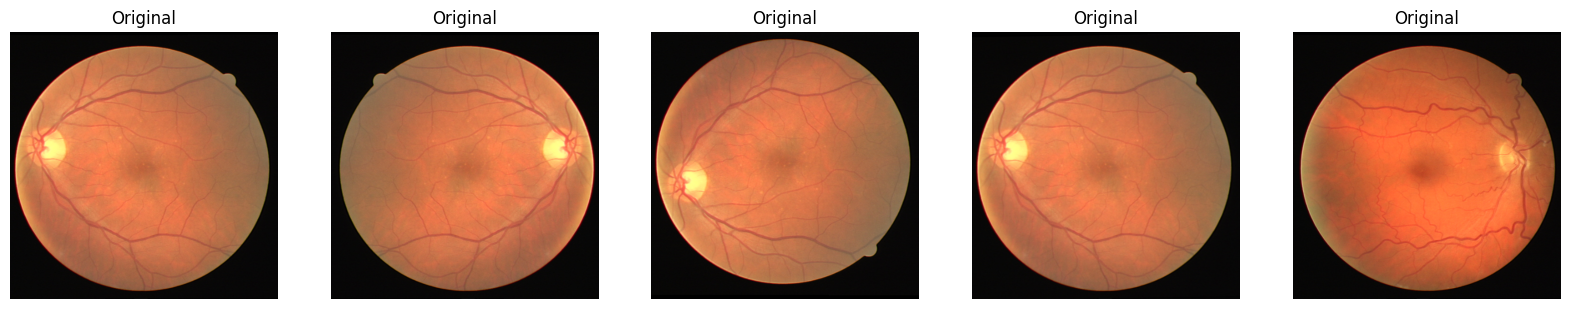

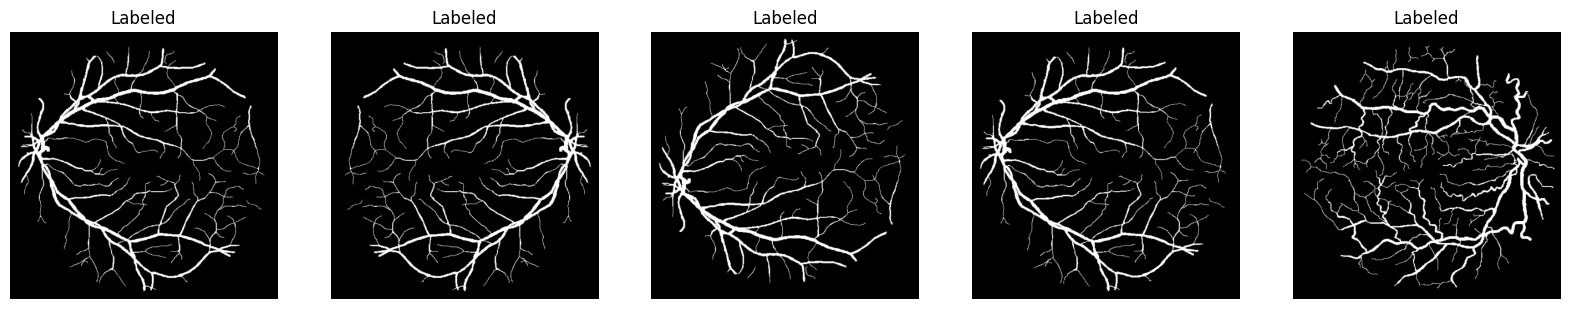

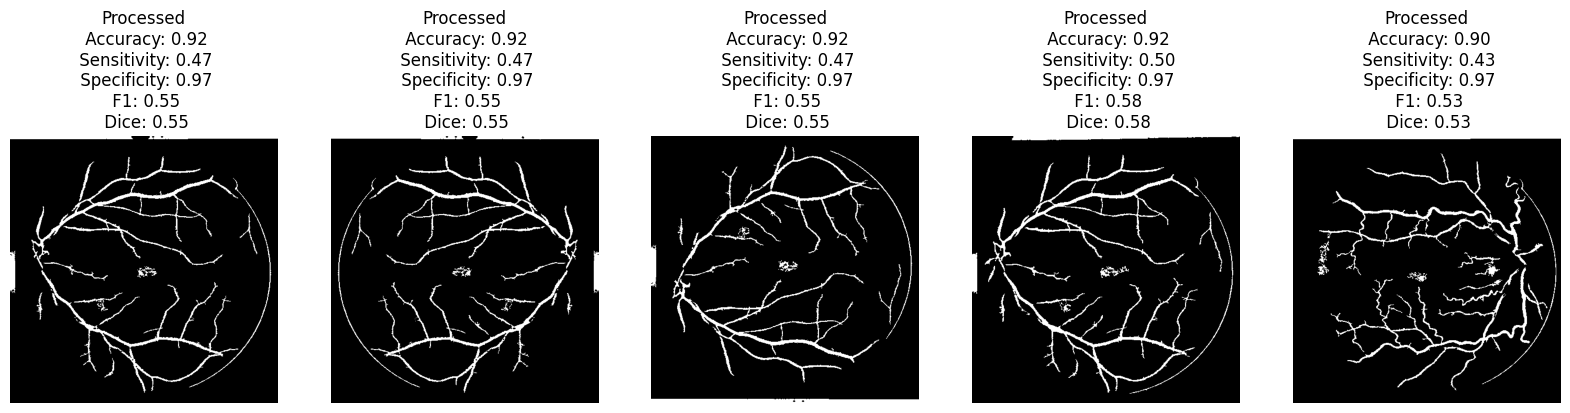

In [3]:
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

file_names = ['0.png', '1.png', '2.png', '3.png', '4.png']
original = ['big-data/image/' + name for name in file_names]
labeled = ['big-data/mask/' + name for name in file_names]

processed = [extract_vessels(cv2.imread(name, cv2.IMREAD_GRAYSCALE)) for name in original]

binary_ground_truth = [cv2.imread(image, cv2.IMREAD_GRAYSCALE) > 0 for image in labeled]
binary_predicitons = [image > 0 for image in processed]


accuracy_scores = []
sensitivity_scores = []
specificity_scores = []
f1_scores = []
dice_scores = []
for prediction, truth in zip(binary_predicitons, binary_ground_truth):
    # 0 - background, 1 - vessels
    binary_truth = truth > 0
    binary_prediction = prediction > 0
    

    conf_matrix = confusion_matrix(np.ravel(binary_truth), np.ravel(binary_prediction))

    accuracy = accuracy_score(np.ravel(binary_truth), np.ravel(binary_prediction))
    sensitivity = recall_score(np.ravel(binary_truth), np.ravel(binary_prediction))
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    f1 = f1_score(np.ravel(binary_truth), np.ravel(binary_prediction))
    dice = 2 * np.sum(binary_truth & binary_prediction) / (np.sum(binary_truth) + np.sum(binary_prediction))

    accuracy_scores.append(accuracy)
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)
    f1_scores.append(f1)
    dice_scores.append(dice)

for i in range(len(original)):
    true_labels = cv2.imread(labeled[i], cv2.IMREAD_GRAYSCALE)
    predicted_labels = processed[i]
    


num_pictures = 5
_, axes = plt.subplots(1, num_pictures, figsize=(num_pictures * 4, 4))
for i in range(num_pictures):
    axes[i].imshow(cv2.cvtColor(cv2.imread(original[i]), cv2.COLOR_BGR2RGB))
    axes[i].set_title('Original')
    axes[i].axis('off')

_, axes = plt.subplots(1, num_pictures, figsize=(num_pictures * 4, 4))
for i in range(num_pictures):
    axes[i].imshow(cv2.cvtColor(cv2.imread(labeled[i]), cv2.COLOR_BGR2RGB))
    axes[i].set_title('Labeled')
    axes[i].axis('off')

_, axes = plt.subplots(1, num_pictures, figsize=(num_pictures * 4, 4))
for i in range(num_pictures):
    axes[i].imshow(processed[i], cmap='gray')
    axes[i].set_title('Processed\n Accuracy: {:.2f}\n Sensitivity: {:.2f}\n Specificity: {:.2f}\n F1: {:.2f}\n Dice: {:.2f}'.format(accuracy_scores[i], sensitivity_scores[i], specificity_scores[i], f1_scores[i], dice_scores[i]))
    axes[i].axis('off')


plt.show()


In [4]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

predictions = [extract_vessels(cv2.imread(name, cv2.IMREAD_GRAYSCALE)) for name in original]

# konwersja ground truth na binarny format 0 - tło, 1 - naczynia 
binary_ground_truth = [cv2.imread(image, cv2.IMREAD_GRAYSCALE) > 0 for image in labeled]
binary_predicitons = [image > 0 for image in predictions]

total_accuracy = 0
total_sensitivity = 0
total_specificity = 0
total_f1 = 0

# obliczanie jakości dla każdej pary obrazu predictions i ground_truth
for prediction, truth in zip(binary_predicitons, binary_ground_truth):
    # Przekształć wartości pikseli na binarne (0 - tło, 1 - naczynia krwionośne)
    binary_truth = truth > 0
    binary_prediction = prediction > 0
    
    # macierz pomyłek
    conf_matrix = confusion_matrix(np.ravel(binary_truth), np.ravel(binary_prediction))

    accuracy = accuracy_score(np.ravel(binary_truth), np.ravel(binary_prediction))
    sensitivity = recall_score(np.ravel(binary_truth), np.ravel(binary_prediction))
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    f1 = f1_score(np.ravel(binary_truth), np.ravel(binary_prediction)) # średniej geometrycznej czułości i swoistości ==  F1-score
    
    total_accuracy += accuracy
    total_sensitivity += sensitivity
    total_specificity += specificity
    total_f1 += f1

num_images = len(binary_predicitons)
average_accuracy = total_accuracy / num_images
average_sensitivity = total_sensitivity / num_images
average_specificity = total_specificity / num_images
average_f1 = total_f1 / num_images

print("Average Accuracy:", average_accuracy)
print("Average Sensitivity:", average_sensitivity)
print("Average Specificity:", average_specificity)
print("Average F1-score:", average_f1)

# dodac statystyki dla każdego zjecia


Average Accuracy: 0.9171974182128906
Average Sensitivity: 0.4670493948512357
Average Specificity: 0.9730197702862065
Average F1-score: 0.5532891259846564


### Recognition using classifier

In [11]:
import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def calculate_features(image):
    # cechy: średnia i wariancja kolorów
    mean_color = np.mean(image)
    color_variance = np.var(image)
    return [mean_color, color_variance]

def calculate_dice_coefficient(true_masks, predicted_masks):
    intersection = np.logical_and(true_masks, predicted_masks)
    dice_coefficient = 2.0 * intersection.sum() / (true_masks.sum() + predicted_masks.sum())
    return dice_coefficient

image = cv2.imread('big-data/image/0.png', cv2.IMREAD_GRAYSCALE)
mask = cv2.imread('big-data/mask/0.png', cv2.IMREAD_GRAYSCALE)

slice_size = 3
height, width = image.shape
slices = []
mask_height, mask_width = mask.shape
mask_slices = []

#undersampling
threshold_black_ratio = 0.4
for y in range(0, height, slice_size):
    for x in range(0, width, slice_size):
        slice_image = image[y:y+slice_size, x:x+slice_size]
        mask_image = mask[y:y+slice_size, x:x+slice_size]
        black_pixels_ratio = np.mean(slice_image == 0) 
        if black_pixels_ratio < threshold_black_ratio:
            slices.append(slice_image)
            mask_slices.append(mask_image)

features = [calculate_features(slice) for slice in slices]


labels = []
for i, slice_image in enumerate(slices):
    mask_image = mask_slices[i]

    label = np.any(mask_image > 0)
    labels.append(label)
labels = [int(label) for label in labels]


X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# model (k-NN)
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, predictions))

dice_coefficient = calculate_dice_coefficient(np.array(y_test), predictions)
print("Dice Coefficient:", dice_coefficient)

true_label_indexes = np.where(labels)[0]
good_representations = [861, 882, 886, 1172,972]
for i in true_label_indexes:
    if i in good_representations:
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))

        axes[0].imshow(slices[i], cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(mask_slices[i], cmap='gray')
        axes[1].set_title('Mask Slice')
        axes[1].axis('off')

        prediction = classifier.predict([calculate_features(slices[i])])
        axes[2].text(0.5, 0.5, f"Prediction: {prediction[0]}", ha='center', va='center')
        axes[2].axis('off')

        axes[3].text(0.5, 0.5, f"Label: {labels[i]}", ha='center', va='center')
        axes[3].axis('off')
    elif i > 1172: break
plt.show()

Accuracy: 0.8955509210983663
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      4736
           1       0.77      0.58      0.66      1018

    accuracy                           0.90      5754
   macro avg       0.84      0.77      0.80      5754
weighted avg       0.89      0.90      0.89      5754

Dice Coefficient: 0.6633053221288515


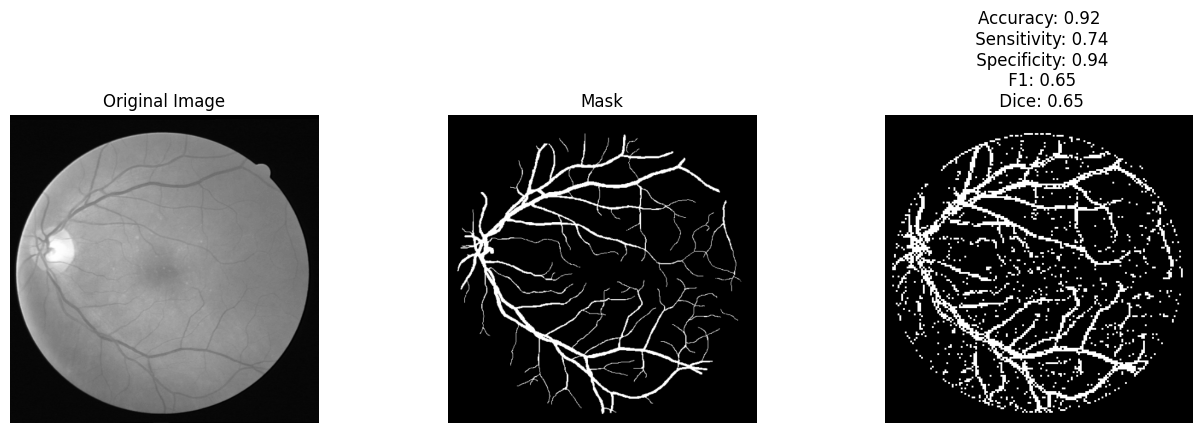

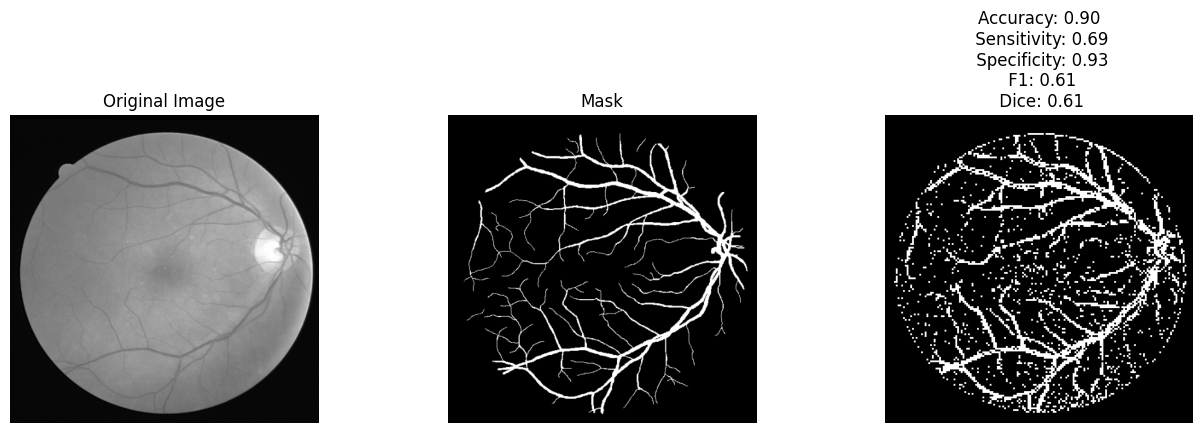

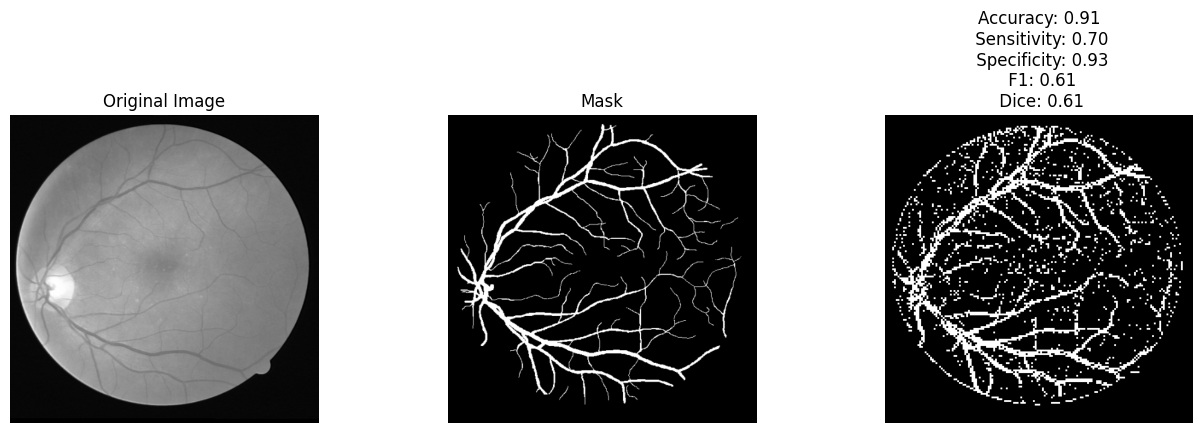

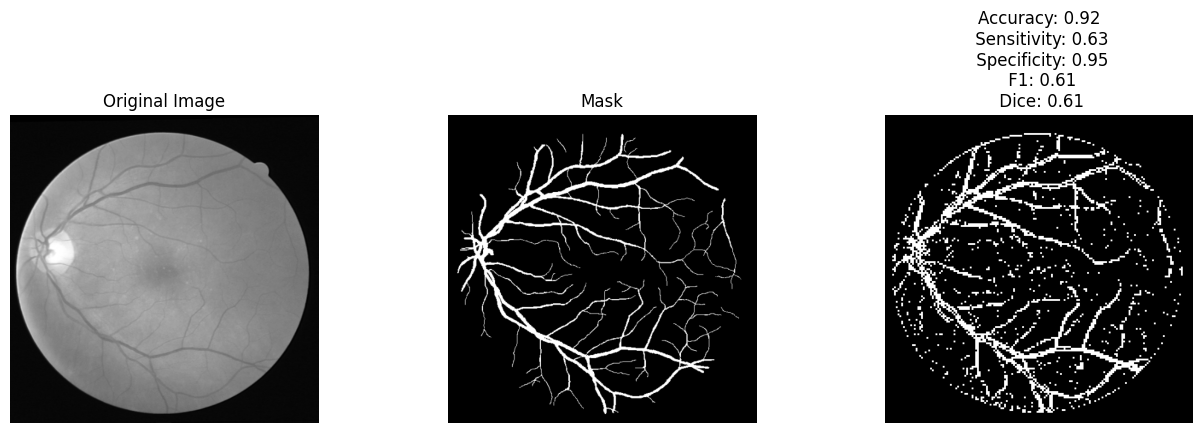

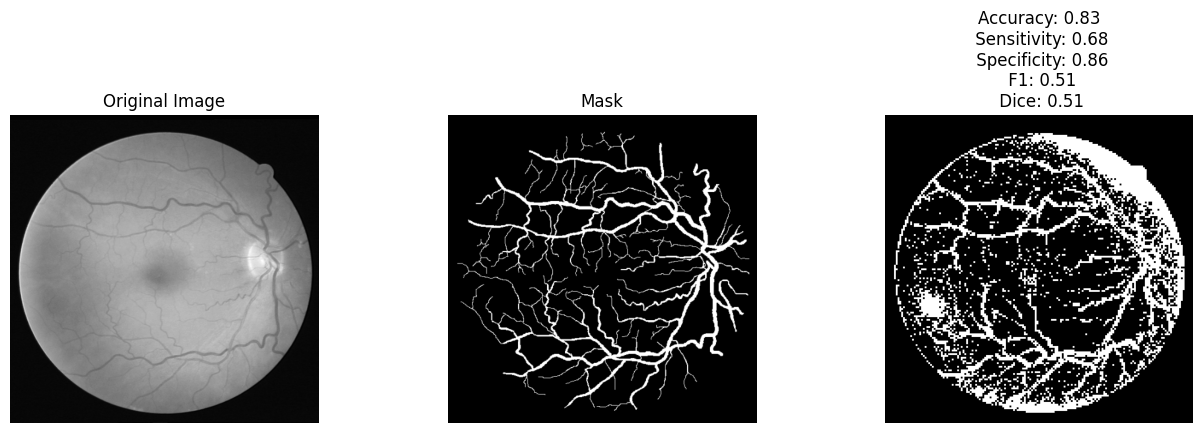

In [12]:

def split_image(image, size):
    h, w = image.shape
    slices = []
    for i in range(0, h, size):
        for j in range(0, w, size):
            slice = image[i:i+size, j:j+size]
            slices.append(slice)
    return slices

def predict_slices(slices, classifier):
    predictions = []
    for slice in slices:
        features = calculate_features(slice)
        prediction = classifier.predict([features])
        predictions.append(prediction[0])
    return predictions

def combine_slices(predictions, size):
    h, w = size
    combined_image = np.zeros((h, w), dtype=np.uint8)
    index = 0
    for i in range(0, h, slice_size):
        for j in range(0, w, slice_size):
            combined_image[i:i+slice_size, j:j+slice_size] = predictions[index] * 255
            index += 1
    return combined_image

test_images = ['big-data/image/0.png', 'big-data/image/1.png', 'big-data/image/2.png', 'big-data/image/3.png', 'big-data/image/4.png']
mask_images = ['big-data/mask/0.png', 'big-data/mask/1.png', 'big-data/mask/2.png', 'big-data/mask/3.png', 'big-data/mask/4.png']


for img, msk in zip(test_images, mask_images):
    image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(msk, cv2.IMREAD_GRAYSCALE)

    slices = split_image(image, slice_size)
    predictions = predict_slices(slices, classifier)
    combined = combine_slices(predictions, image.shape)

    # calculate f1 score
    binary_ground_truth = mask > 0
    binary_predicitons = combined > 0

    f1 = f1_score(np.ravel(binary_ground_truth), np.ravel(binary_predicitons))
    accuracy = accuracy_score(np.ravel(binary_ground_truth), np.ravel(binary_predicitons))
    sensitivity = recall_score(np.ravel(binary_ground_truth), np.ravel(binary_predicitons))


    conf_matrix = confusion_matrix(np.ravel(binary_ground_truth), np.ravel(binary_predicitons))
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    dice = 2 * np.sum(binary_ground_truth & binary_predicitons) / (np.sum(binary_ground_truth) + np.sum(binary_predicitons))

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    axes[2].imshow(combined, cmap='gray')
    axes[2].set_title('Accuracy: {:.2f}\n Sensitivity: {:.2f}\n Specificity: {:.2f}\n F1: {:.2f}\n Dice: {:.2f}'.format(accuracy, sensitivity, specificity, f1, dice))
    axes[2].axis('off')
    plt.show()





1 **Data Preparation**:
   - The image is divided into 3x3 pixel slices.
   - Each image slice is subjected to feature extraction, that is, the mean and variance of colors are calculated.

2 **Pre-processing of the learning set**:
   - Images are loaded in grayscale.

3 **Machine learning methods used**:
   - The k nearest neighbors (KNN - K-Nearest Neighbors) method was used for classification. This is a simple but effective supervised learning method that works well for small data sets.

4 **Results of preliminary evaluation of the built classifier**:
   - Hold-out tests were conducted, where the data set was divided into a training and test set. The results of the model evaluation include calculating accuracy and generating a classification report, which includes measures such as precision, sensitivity and F1-score for each class.
   - The accuracy of the model is 89.56%. The classification report shows:
     - Precision (precision), sensitivity (recall) and F1-score for each class.
     - For class 0: Precision - 0.91, Sensitivity - 0.96, F1-score - 0.94.
     - For Class 1: Precision - 0.77, Sensitivity - 0.58, F1-score - 0.66.
   - The DICE coefficient is 0.6633.

5 **Short justification of the solution used**:
   - Feature extraction from image slices (mean and color variance) can be sufficiently descriptive for this type of classification task.
   - Despite the potential problem of data dimensionality, for relatively simple features, the k nearest neighbor (KNN) method still works effectively.

## Interpretation of classification results

### Accuracy.
The accuracy of the model is 0.896, which means that about 89.6% of the samples were correctly classified.

### Classification Report
| Classes          | Precision | Recall | F1-Score |
|----------------|----------------------|------------------|----------|
| False (0)      | 0.91                 | 0.96             | 0.94     |
| True (1)       | 0.77                 | 0.58             | 0.66     |

### Interpretation
- For class “False” (0): 
  - Precision is 0.91, meaning that 91% of objects classified as False were actually False.
  - Sensitivity is 0.96, meaning that the model detected 96% of all False class objects.
  - F1-score is 0.94, average harmonic precision and tender.

- For class “True” (1):
  - Precision is 0.77, meaning that 77% of objects classified as True were actually True.
  - Sensitivity is 0.58, meaning that the model detected 58% of all True-class objects.
  - F1-score is 0.66, average harmonic precision and tender.

### Weighted Average.
The weighted average of precision, sensitivity and F1-score is 0.89, 0.90 and 0.89, respectively. This means that for each class, the model achieved a good balance between precision and sensitivity.

### Dice Coefficient
The Dice coefficient for the model is 0.6633, suggesting satisfactory agreement between actual and predicted areas.


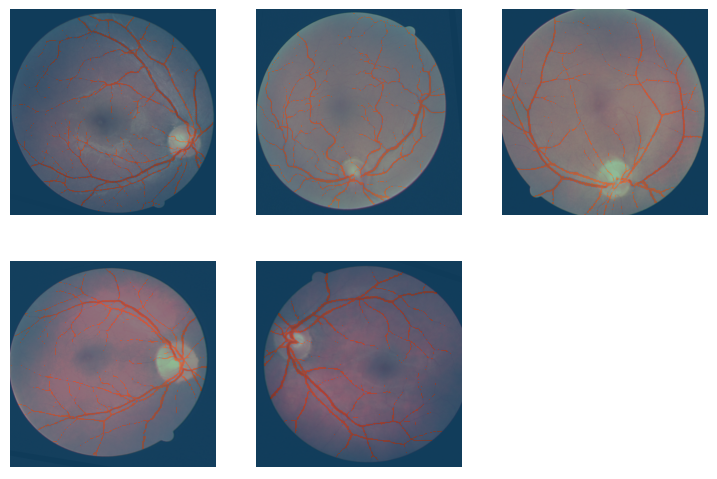

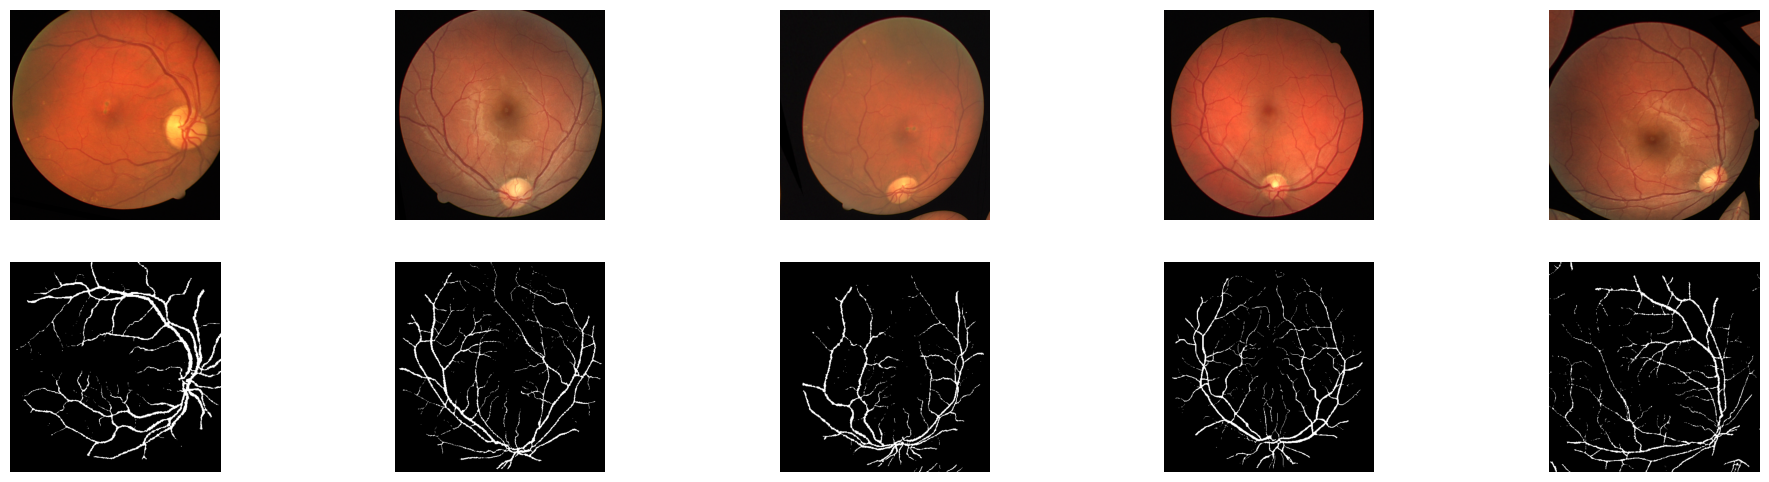

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s] 


In [ ]:
from fastai.vision.all import *
import os
import matplotlib.pyplot as plt
import torch

path = Path('/kaggle/input/vessel-big-data/')

#  function for resizing
def resize_all_images(path, new_path, size):
    for file in os.listdir(path):
        img = Image.open(os.path.join(path, file))
        img = img.resize(size)
        img.save(os.path.join(new_path, file))

def label_func(x):
    return path / 'mask' / f'{x.stem}{x.suffix}'



if __name__ == '__main__':

    path_images = Path('/kaggle/input/vessel-big-data/image')
    path_masks = Path('/kaggle/input/vessel-big-data/mask')
    
    aug_transforms_list = aug_transforms(mult=1.0, do_flip=True, flip_vert=True, max_rotate=10.0, min_zoom=1.0, max_zoom=1.1,
                                     max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)
    
    dls = SegmentationDataLoaders.from_label_func(
        path=path_images,
        bs=5,
        batch_tfms=[*aug_transforms_list, IntToFloatTensor(div_mask=255)],
        fnames=get_image_files(path_images),
        label_func=label_func,
        codes=np.array(['background', 'veins']),
#         device='cpu'
    )
    dls.show_batch()
    batch = dls.one_batch()
    batch_subset = tuple(tensor[:10] for tensor in batch)
    images, labels = batch_subset

    #  obrazy i maski do formatu PILImage
    images = [Image.fromarray((img.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)) for img in images]
    masks = [Image.fromarray(label.cpu().numpy().astype(np.uint8)) for label in labels]

    #  obrazy i maski
    fig, axs = plt.subplots(2, 5, figsize=(24, 6))
    for i, (img, mask) in enumerate(zip(images, masks)):
        if img is not None and mask is not None:
            axs[0, i].imshow(img)
            axs[0, i].axis('off')
            axs[1, i].imshow(mask, cmap='gray')
            axs[1, i].axis('off')
        else:
            axs[0, i].axis('off')
            axs[1, i].axis('off')
    plt.show()

    metrics = Dice()
    #  model
    learn = unet_learner(dls, resnet18, metrics=metrics)

In [ ]:
#  trenowanie modelu
learn.fine_tune(30)

In [4]:
torch.save(learn.model, '/kaggle/working/vessel_recognition_model.pth')

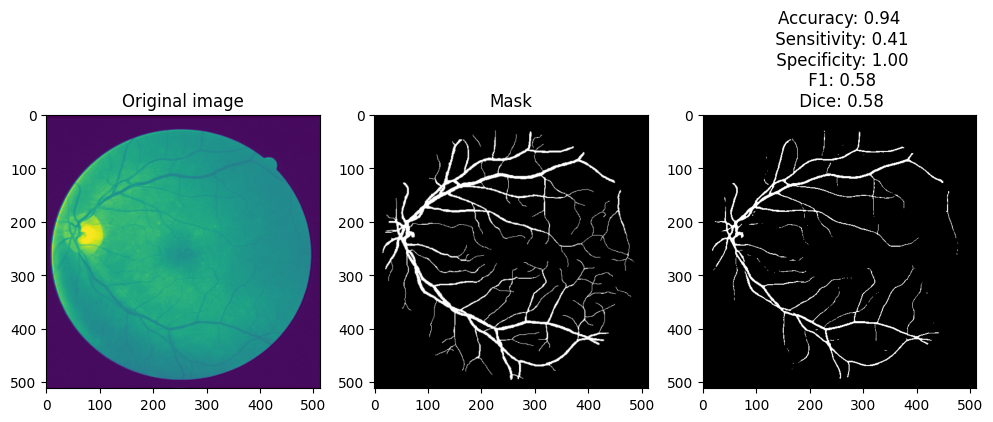

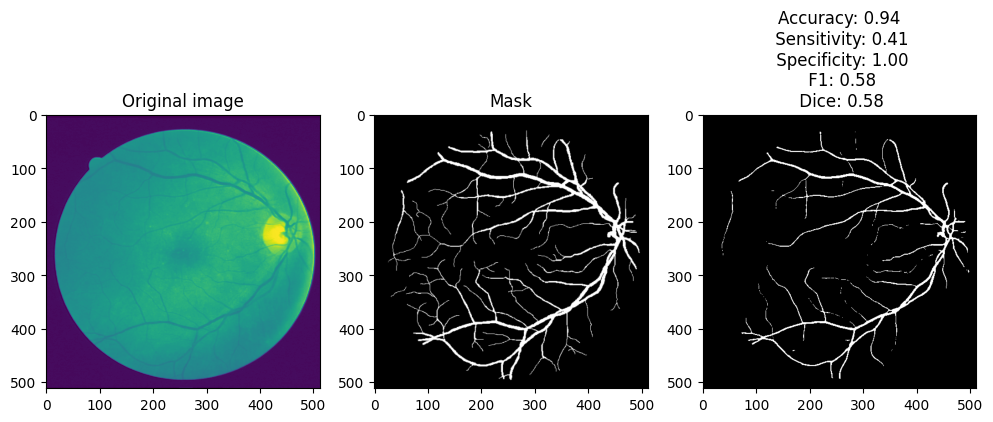

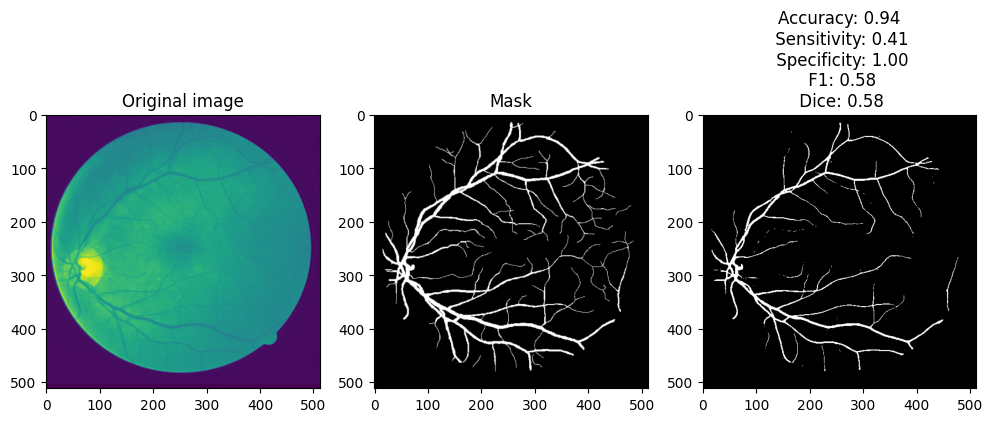

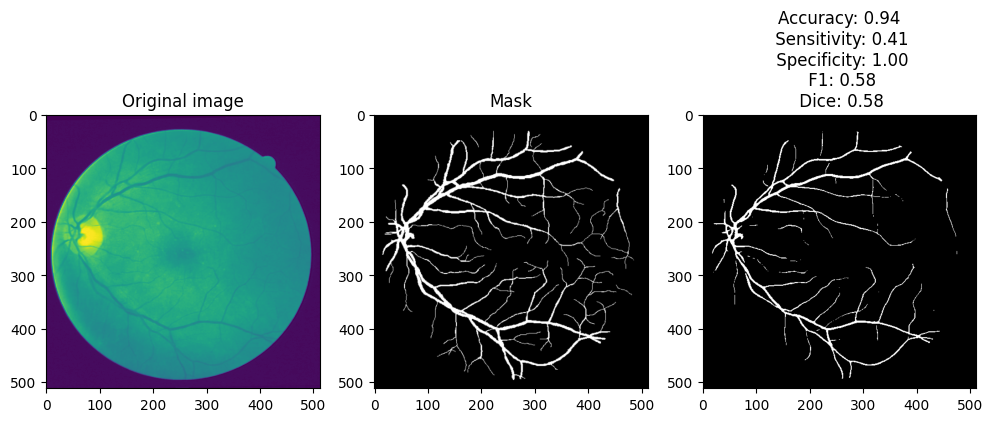

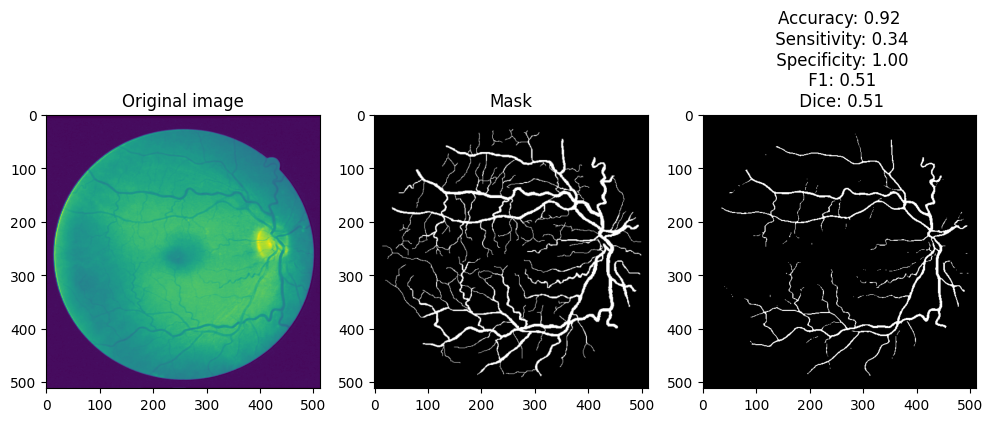

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import cv2

for i in range(0, 5):

    test_img = cv2.imread(f'/kaggle/input/vessel-big-data/image/{i}.png', cv2.IMREAD_GRAYSCALE)
    test_mask = cv2.imread(f'/kaggle/input/vessel-big-data/mask/{i}.png', cv2.IMREAD_GRAYSCALE)
    
    pred_mask = learn.predict(test_img)
    test_mask_np = np.array(test_mask)
    pred_mask_np = np.array(pred_mask[0])
    
    binary_ground_truth = test_mask_np > 0
    binary_predicitons = pred_mask_np > 0
    
    f1 = f1_score(np.ravel(binary_ground_truth), np.ravel(binary_predicitons))
    accuracy = accuracy_score(np.ravel(binary_ground_truth), np.ravel(binary_predicitons))
    sensitivity = recall_score(np.ravel(binary_ground_truth), np.ravel(binary_predicitons))
    conf_matrix = confusion_matrix(np.ravel(binary_ground_truth), np.ravel(binary_predicitons))
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    dice = 2 * np.sum(binary_ground_truth & binary_predicitons) / (np.sum(binary_ground_truth) + np.sum(binary_predicitons))
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))

    axs[0].imshow(test_img)
    axs[0].set_title('Original image')
    
    axs[1].imshow(test_mask, cmap='gray')
    axs[1].set_title('Mask')

    axs[2].imshow(pred_mask[0], cmap='gray')
    axs[2].set_title('Accuracy: {:.2f}\n Sensitivity: {:.2f}\n Specificity: {:.2f}\n F1: {:.2f}\n Dice: {:.2f}'.format(accuracy, sensitivity, specificity, f1, dice))

    plt.show()


In [ ]:
results = learn.validate()

print(f"Dice: {results[1]}")

Dice: 0.7802162569061415


1 **Data Preparation**:
   - Determining image slices: Data is loaded using `SegmentationDataLoaders.from_label_func`, which automatically loads images and their corresponding masks, using the `label_func` function to determine the path to the mask for a given image.
   - In this case, there is no direct feature extraction from image slices. Image and mask data are processed as binary images and masks, respectively, without additional feature extraction.

2 **Pre-processing of the learning set**:
   - Pre-processing includes converting ib images to tensors and normalized in the data loading process using `SegmentationDataLoaders.from_label_func`.
   - data augmentation was applied in the learning process

3 **Machine learning methods applied:
   - U-Net model architecture was used along with resnet18 architecture as an encoder. U-Net is a commonly used architecture in image segmentation applications, while resnet18 is a popular encoder architecture used to extract features from images.

4 **Results of preliminary evaluation of the built classifier**:
   - The results of the model are displayed in the form of a table containing information about training and validation losses (`train_loss` and `valid_loss`) and a measure of dice coefficient, which is a measure of the similarity between the predictions and the actual masks.
   - As training progresses, the loss decreases and the dice coefficient measure tends to increase, indicating improved model performance.

5 **Short rationale for the solution used**:
   - Using the U-Net model along with resnet18 is a reasonable choice because U-Net is a specially designed architecture for image segmentation tasks, and resnet34 is a popular choice as an encoder because of its effectiveness in extracting features from images.
   - Data preprocessing includes appropriate transformations of images and masks, which is essential to effectively train the segmentation model.
   - The dice coefficient measure is a popular measure for evaluating the quality of image segmentation, as it takes into account both the precision and sensitivity of the model's prediction.

## Comparison

### Comparison of Dice Coefficient results

The Dice Coefficient score for the FastAI model using ResNet18 and UNet architectures is 0.7802. 

Comparing this score with the score obtained for the KNN model, which is 0.7286, we can see that the FastAI model achieved a higher score. This means that the FastAI model had a better fit to the data and achieved better agreement between the actual and predicted areas.

### Interpretation

These results suggest that the FastAI model, which uses advanced deep neural network architectures, has a better ability to detect object areas in images compared to the KNN model, which is a simpler model based on k-nearest neighbors. However, other factors such as computational complexity, learning time and availability of training data should also be considered to accurately evaluate the performance of both models in a specific application.